In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy

## Functions

In [2]:
class RegressionCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(RegressionCNN, self).__init__()
        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class RegressionANN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(RegressionANN, self).__init__()
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = (input_shape[1]) * (input_shape[2])

        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(self.flattened_size,1024)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.flatten(x)
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = (self.fc7(x))
        return x

class Regression_Linear(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(Regression_Linear, self).__init__()
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = (input_shape[1]) * (input_shape[2])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size,num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = self.flatten(x)
        x = (self.fc1(x))
        return x


class SpatialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.nan_to_num(torch.tensor(X, dtype=torch.float32))
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(0)

class SpatialDataset_ANN(Dataset):
    def __init__(self, X, y):
        self.X = torch.nan_to_num(torch.tensor(X, dtype=torch.float32)).squeeze()
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(0)

In [5]:
Data_ = xr.open_dataset('../Data_Staging/Mamalakis_Dataset/scp_synth_exm_data.nc')
Data_

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 36, time: 1000000, lin_segment: 6)
Coordinates:
  * lat      (lat) float64 89.5 79.5 69.5 59.5 49.5 ... -50.5 -60.5 -70.5 -80.5
  * lon      (lon) float64 0.5 10.5 20.5 30.5 40.5 ... 320.5 330.5 340.5 350.5
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 1e+06 1e+06 1e+06 1e+06
Dimensions without coordinates: lin_segment
Data variables:
    y        (time) float64 ...
    Cnt      (time, lon, lat) float64 ...
    SSTrand  (time, lon, lat) float64 ...
    W        (lin_segment, lon, lat) float64 ...
Attributes:
    Title:        CSU Synthetic Attribution Benchmark Dataset
    Study DOI:    10.1017/eds.2022.7
    Institution:  Colorado State University
    Disclaimer:   This is a synthetic dataset. No data corresponds to observa...

## Import Dataset

In [3]:
Data_ = xr.open_dataset('../Data_Staging/Mamalakis_Dataset/scp_synth_exm_data.nc')
Data_train = np.expand_dims(Data_['SSTrand'].isel(time=slice(0,900000)),1)
Y_train = np.array(Data_['y'].isel(time=slice(0,900000)))

Data_val = np.expand_dims(Data_['SSTrand'].isel(time=slice(950000,1000000)),1)
Y_val = np.array(Data_['y'].isel(time=slice(950000,1000000)))

Data_test = np.expand_dims(Data_['SSTrand'].isel(time=slice(900000,950000)),1)
Y_test = np.array(Data_['y'].isel(time=slice(900000,950000)))

## Train Model

In [7]:
rem = Data_train.shape
input_shape = (rem[1],rem[2],rem[3]) # Example input shape (C, H, W)
model = RegressionCNN(input_shape=input_shape, num_classes=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

train_dataset = SpatialDataset(Data_train, Y_train)
val_dataset = SpatialDataset(Data_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 10000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            outputs = model(inputs)
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(Y_val))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 3.6938
MSE: 0.00926
r2: -0.0010766983032226562
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.0094
MSE: 0.00928
r2: -0.0033494234085083008
No improvement in validation accuracy.
Starting Epoch 2
Epoch 2, Loss: 0.0094
MSE: 0.00931
r2: -0.0074961185455322266
No improvement in validation accuracy.
Starting Epoch 3
Epoch 3, Loss: 0.0094
MSE: 0.00933
r2: -0.008803129196166992
No improvement in validation accuracy.
Starting Epoch 4
Epoch 4, Loss: 0.0094
MSE: 0.00932
r2: -0.008271098136901855
No improvement in validation accuracy.
Starting Epoch 5
Epoch 5, Loss: 0.0094
MSE: 0.00932
r2: -0.00765228271484375
No improvement in validation accuracy.
Starting Epoch 6
Epoch 6, Loss: 0.0094
MSE: 0.00931
r2: -0.007110595703125
No improvement in validation accuracy.
Starting Epoch 7
Epoch 7, Loss: 0.0094


KeyboardInterrupt: 

## ANN

In [6]:
rem = Data_train.shape
input_shape = (rem[1],rem[2],rem[3]) # Example input shape (C, H, W)
model = RegressionANN(input_shape=input_shape, num_classes=1)
model.fc0.weight.data = torch.normal(mean=0,std=(1/648),size=(1024, 648))
model.fc0.bias.data.fill_(0)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

train_dataset = SpatialDataset_ANN(Data_train,Y_train)
val_dataset = SpatialDataset_ANN(Data_val,Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 40000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            outputs = model(inputs)
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(Y_val))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.0737
MSE: 0.00081
r2: 0.9126499891281128
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.0009
MSE: 0.00076
r2: 0.9179357290267944
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.0007
MSE: 0.00056
r2: 0.9396390318870544
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.0013
MSE: 0.00096
r2: 0.8961682319641113
No improvement in validation accuracy.
Starting Epoch 4
Epoch 4, Loss: 0.0008
MSE: 0.00056
r2: 0.9398359656333923
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.0011
MSE: 0.00060
r2: 0.9355189204216003
No improvement in validation accuracy.
Starting Epoch 6
Epoch 6, Loss: 0.0008
MSE: 0.00055
r2: 0.9403996467590332
...saving!...
Starting Epoch 7


KeyboardInterrupt: 

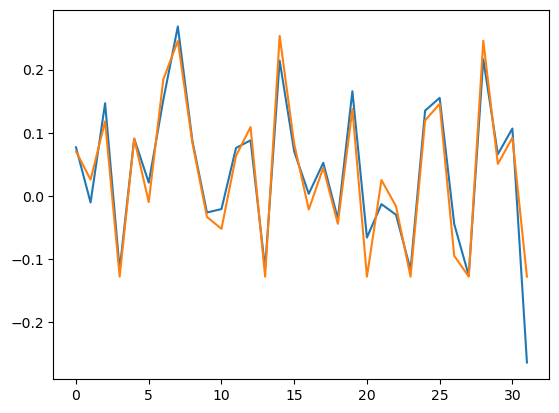

In [8]:
plt.plot(labels.detach().numpy())
plt.plot(outputs.detach().numpy())
plt.show()

## Linear Regression 

In [4]:
rem = Data_train.shape
input_shape = (rem[1],rem[2],rem[3]) # Example input shape (C, H, W)
model = Regression_Linear(input_shape=input_shape, num_classes=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_dataset = SpatialDataset_ANN(Data_train,Y_train)
val_dataset = SpatialDataset_ANN(Data_val,Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 100000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            outputs = model(inputs)
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
            
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(Y_val))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.0078
MSE: 0.00495
r2: 0.46505773067474365
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.0076
MSE: 0.00495
r2: 0.4647061824798584
No improvement in validation accuracy.
Starting Epoch 2
Epoch 2, Loss: 0.0076
MSE: 0.00495
r2: 0.4650322198867798
No improvement in validation accuracy.
Starting Epoch 3
Epoch 3, Loss: 0.0076
MSE: 0.00494
r2: 0.46597975492477417
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.0076
MSE: 0.00493
r2: 0.46711307764053345
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.0076
MSE: 0.00492
r2: 0.4682498574256897
...saving!...
Starting Epoch 6
Epoch 6, Loss: 0.0076
MSE: 0.00491
r2: 0.46932393312454224
...saving!...
Starting Epoch 7
Epoch 7, Loss: 0.0076
MSE: 0.00490
r2: 0.470319926738739
...saving!...
Starting Epoch 8
Epoch 8, Loss: 0.0076
MSE: 0.00489
r2: 0.471235990524292
...saving!...
Starting Epoch 9
Epoch 9, Loss: 0.0076
MSE: 0.00488
r2: 0.4720783829689026
...saving!...
Starting Epoch 10
Epoch 10, Loss: 0.0076
MSE: 0.

KeyboardInterrupt: 

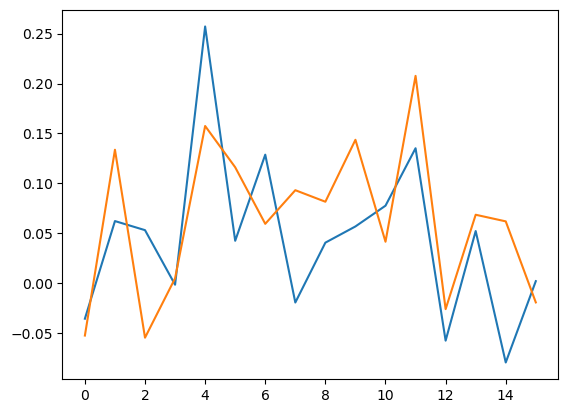

In [7]:
plt.plot(labels.detach().numpy())
plt.plot(outputs.detach().numpy())